# Image segmentation with U-Net
### By: Diego Coello de Portugal Mecke

This notebook aims to:

1) Reimplement [U-Net architecture](https://link.springer.com/content/pdf/10.1007/978-3-319-24574-4_28.pdf) by Ronneberge et al. (2015) for semantic image segmentation. Meaning an encoder-decoder sequence-to-sequence model with skip connections between each layer of the encoder and decoder. There will be some experimentation with a  pretrained encoder (e.g. MobileNetV2).

2) An Augment class and the function **iou** which computes a per-class Intersection-over-Union score will be implemented. The augment class should increase the model performance while the **iou** metric should be a better way to review the model performance.

The trainning will be stopped at 20 iterations due to time constrains. Different architectures and training procedures will be compared.

Lastly, there will be a short experiment on finetuning.

----

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
import torch

In [2]:
#Avoids error with matplotlib
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Load Data

In [3]:
#Transformation and loading functions
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)
    cl1 =  tf.cast(tf.greater(input_mask,1.),tf.float32)*2
    cl2 =  tf.cast(tf.less(input_mask,1.),tf.float32)
    input_mask = tf.zeros(tf.shape(input_mask))+cl1+cl2
    
    return input_image, input_mask#, input_mask2

In [4]:
#----------------Code in google colab to download data------------------------
#I have some issues with running tfds package in local, so I downloaded the dataset to use it locally

#import tensorflow_datasets as tfds

#dataset, info = tfds.load('oxford_iiit_pet', with_info=True)

#save dataset
# tf.data.experimental.save(dataset['train'], 'data_file_train')
# tf.data.experimental.save(dataset['test'], 'data_file_test')

# #Compress data
# import os
# from zipfile import ZipFile

# with ZipFile("train.zip", 'w') as zip:
#    for path, directories, files in os.walk("data_file_train"):
#        for file in files:
#            file_name = os.path.join(path, file)
#            zip.write(file_name)

# with ZipFile("train.zip", 'w') as zip:
#    for path, directories, files in os.walk("data_file_train"):
#        for file in files:
#            file_name = os.path.join(path, file)
#            zip.write(file_name)

In [4]:
#Hyperparameters
TRAIN_LENGTH = 3680 #info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
OUTPUT_CLASSES = 3

#Load data
train_images = tf.data.experimental.load('train').map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = tf.data.experimental.load('test').map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.


In [5]:
resize_to = 360 #128+64
crop_to = 128
rotation =  (-1, 1)

aux_aug = tf.keras.Sequential([
            #layers.Resizing(resize_to, resize_to),
            #layers.RandomCrop(crop_to, crop_to),
            layers.RandomRotation(rotation)
          ])

class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # Add data augmentation
  
  def call(self, inputs, labels):
    # Add data augmentation
    joined = tf.concat([inputs,labels], axis=3)
    
    #Random horizontal flip
    joined_aug = tf.image.random_flip_left_right(joined)
    
    #Split labels and images
    inputs_aug = joined_aug[:,:,:,:3]
    labels_aug = joined_aug[:,:,:,3:]
    return inputs_aug, labels_aug


AugClass = Augment()

In [6]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

X (64, 128, 128, 3) Y (64, 128, 128, 1)


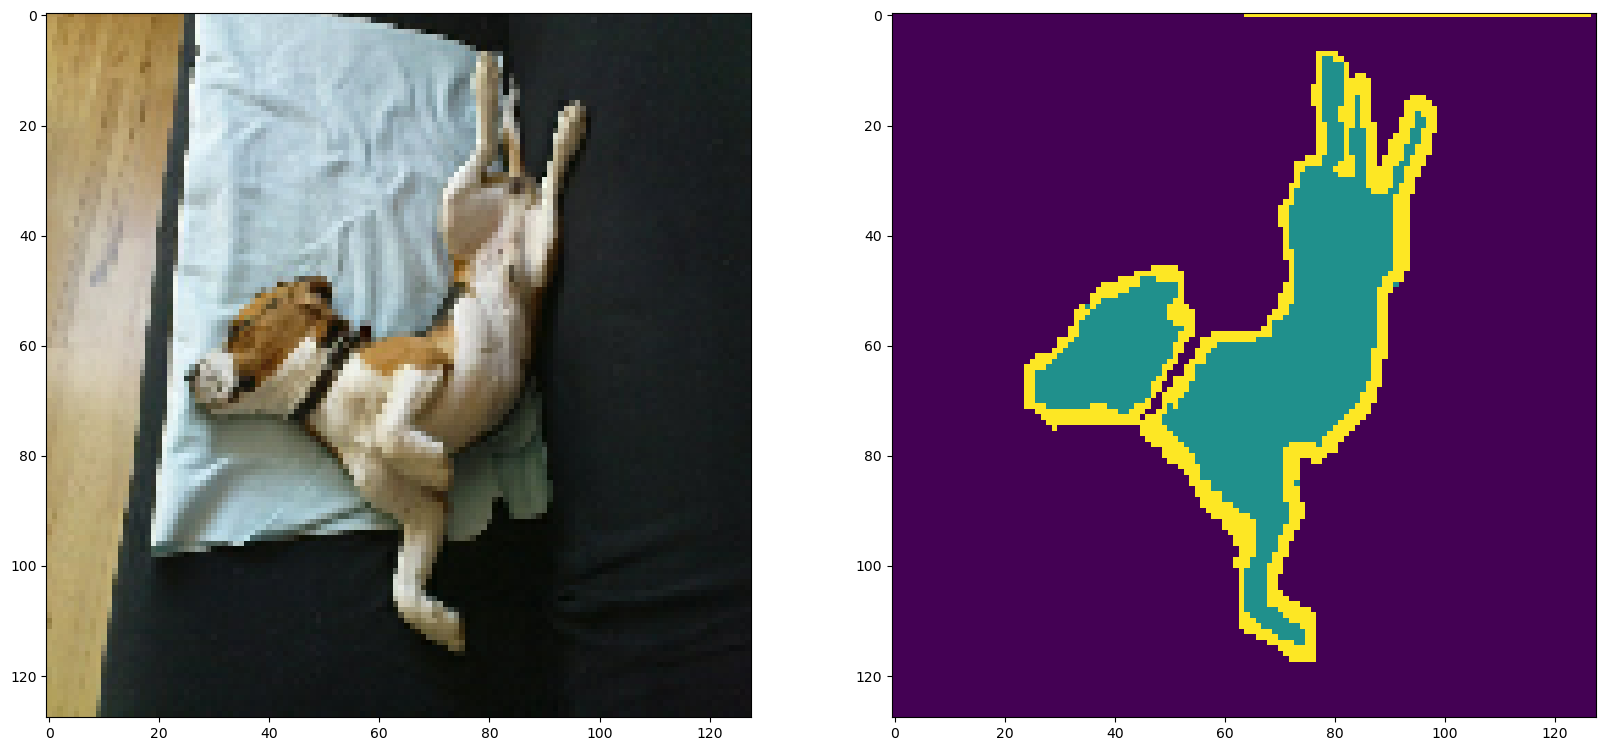

In [8]:
for x,y in train_batches:
    print("X",x.shape, "Y",y.shape)
    
    fig = plt.figure(figsize=(20,10))
    gs  = grid.GridSpec(1,2)

    i = 0
    a = x[i]
    b = y[i]
    
    ax = plt.subplot(gs[0,0])
    ax.imshow(a)
    
    ax = plt.subplot(gs[0,1])
    ax.imshow(b)
    break

# Create U-Net Model

## Load pretrained model MobileNet2

In [7]:
# Using pretrained TF models
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False, weights='imagenet')

# Names of blocks
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]

# Get outputs for each block
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Wrap model to generate multiple outputs instead of one
base_model = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
base_model.trainable = False

In [10]:
for x,y in train_batches:
    outs = base_model.predict(x)
    print("X",x.shape, "Y",y.shape)
    for i, out_layer in enumerate(outs):
        print("layer:",i+1,"\n  output:",out_layer.shape)
    break

2/2 [==============================] - 4s 6ms/step
X (64, 128, 128, 3) Y (64, 128, 128, 1)
layer: 1 
  output: (64, 64, 64, 96)
layer: 2 
  output: (64, 32, 32, 144)
layer: 3 
  output: (64, 16, 16, 192)
layer: 4 
  output: (64, 8, 8, 576)
layer: 5 
  output: (64, 4, 4, 320)


## Implement Decoder, U-Net and other functionalitites

In [8]:
class Decoder(tf.keras.Model):
    def __init__(self,num_classes=3, reg=0.001):
        super(Decoder, self).__init__()
        
        #Deconvolutions
        def genDeconv(filters, kernel=(2,2), strides=(2,2)):
            return layers.Conv2DTranspose(filters, kernel, padding="same", activation="relu", strides=(2,2), kernel_regularizer=l2(reg))
        
        deconv_1 = genDeconv(576)
        deconv_2 = genDeconv(192)
        deconv_3 = genDeconv(144)
        deconv_4 = genDeconv(96)
        deconv_5 = genDeconv(48) #To reescale back to 128x128
        
        self.deconv = [deconv_1, deconv_2, deconv_3, deconv_4, deconv_5]
        
        #Processing layers
        def genConv(filters,kernels=[(3,3),(3,3)]):
            return tf.keras.Sequential([layers.BatchNormalization(),\
                                        layers.Conv2D(filters[0], kernels[0], padding="same", activation="relu", kernel_regularizer=l2(reg)),\
                                        layers.BatchNormalization(),\
                                        layers.Conv2D(filters[1], kernels[1], padding="same", activation="relu", kernel_regularizer=l2(reg)),
                                        layers.BatchNormalization()])
        
        #Extra layer at the end to rescale to 128x128
        self.block = [genConv((576,192)), genConv((576,192)), genConv((192,144)), genConv((144,96)), genConv((96,32)), genConv((24,12))]  
        
        #Output layer
        self.out = layers.Conv2D(num_classes,(1,1),padding="same")

    def call(self, inputs, training=False):
        
        prev = self.block[0](inputs[4])
        for i in range(4):
            concat = tf.concat([self.deconv[i](prev),inputs[3-i]], axis=3)
            prev = self.block[i+1](concat)
            
        #Extra layer to get back to 128x128
        rescale = self.deconv[4](prev)
        prev = self.block[5](rescale)

        return self.out(prev)   

In [9]:
class Unet(tf.keras.Model):
    
    def __init__(self, num_classes=3, reg=0.001):
        super(Unet, self).__init__()


        # Create the feature extraction model
        self.encoder = base_model# TODO

        # In case you load a pretrained encoder and dont want to train it to speed up computation
        #self.encoder.trainable = False
        
        self.decoder = Decoder(num_classes=num_classes, reg=reg)
        
    def call(self, inputs, training = False):
        
        embedding = self.encoder(inputs)

        # Here the embeddings is a list of outputs for each U-Net level
        
        pred = self.decoder(embedding)
        
        return pred

In [8]:
def iou(target, prediction):

    # TODO: Multiclass IoU that can be passed as a metric to tensorflow (if possible this should return an iou score per class for evaluation)
    pred_argmax = tf.argmax(prediction, axis=3)
    target = target[:,:,:,0]
    
    target_0 = tf.cast(target==0, dtype='int32') #(target_shape[0],target_shape[1],target_shape[2]))
    target_1 = tf.cast(target==1, dtype='int32') #(target_shape[0],target_shape[1],target_shape[2]))
    target_2 = tf.cast(target==2, dtype='int32') #(target_shape[0],target_shape[1],target_shape[2]))
    
    pred_0 = tf.cast(pred_argmax==0, dtype='int32')
    pred_1 = tf.cast(pred_argmax==1, dtype='int32')
    pred_2 = tf.cast(pred_argmax==2, dtype='int32')
    
    and_0 = tf.reduce_sum(tf.multiply(target_0,pred_0))
    or_0 =  tf.reduce_sum(target_0) + tf.reduce_sum(pred_0) - and_0
    score_0 = and_0/or_0
    
    and_1 = tf.reduce_sum(tf.multiply(target_1,pred_1))
    or_1 =  tf.reduce_sum(target_1) + tf.reduce_sum(pred_1) - and_1
    score_1 = and_1/or_1
    
    and_2 = tf.reduce_sum(tf.multiply(target_2,pred_2))
    or_2 =  tf.reduce_sum(target_2) + tf.reduce_sum(pred_2) - and_2
    score_2 = and_2/or_2

    return [score_0, score_1, score_2]

In [9]:
def plot_history(history):
    fig = plt.figure(figsize=(20,5))
    gs = grid.GridSpec(1,3)

    ax = plt.subplot(gs[0,0])
    ax.plot(history.history["loss"],label="Train")
    ax.plot(history.history["val_loss"],label="Test")
    ax.set_title("Loss")

    ax = plt.subplot(gs[0,1])
    ax.plot(history.history["accuracy"],label="Train")
    ax.plot(history.history["val_accuracy"],label="Test")
    ax.set_title("Accuracy")

    ax = plt.subplot(gs[0,2])
    ax.plot(history.history["iou"],label="Train")
    ax.plot(history.history["val_iou"],label="Test")
    ax.set_title("IoU")

    plt.legend()

In [10]:
def get_iou(model, test_batches, total=100):
    ious = []
    count = 0
    for x,y in test_batches.take(total):
        pred = model(x)
        ious.append(iou(y,pred))
    return np.mean(ious,0)

In [11]:
def plot_image_comparison(model, test_batches):

    i = 0
    
    for x,y in test_batches.take(1):
        pred = model(x)
    
    fig = plt.figure(figsize=(30,10))
    gs  = grid.GridSpec(1,3)

    ax = plt.subplot(gs[0,0])
    ax.imshow(x[i])

    ax = plt.subplot(gs[0,1])
    ax.imshow(y[i][:,:,0])

    ax = plt.subplot(gs[0,2])
    ax.imshow(np.argmax(pred,-1)[i])

# Training Model

In [17]:
model = Unet(num_classes=OUTPUT_CLASSES, reg=None)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy',iou])

In [18]:
trainHist = model.fit(x=train_batches, steps_per_epoch=STEPS_PER_EPOCH, epochs=20, validation_data=test_batches, validation_steps=10)

Epoch 1/20
57/57 [==============================] - 26s 269ms/step - loss: 19.8982 - accuracy: 0.7450 - iou: 0.5316 - val_loss: 9.9001 - val_accuracy: 0.5658 - val_iou: 0.1886
Epoch 2/20
57/57 [==============================] - 18s 256ms/step - loss: 5.6242 - accuracy: 0.8926 - iou: 0.7144 - val_loss: 4.0874 - val_accuracy: 0.5658 - val_iou: 0.1886
Epoch 3/20
57/57 [==============================] - 15s 255ms/step - loss: 2.3157 - accuracy: 0.8970 - iou: 0.7246 - val_loss: 2.4350 - val_accuracy: 0.5658 - val_iou: 0.1886
Epoch 4/20
57/57 [==============================] - 15s 255ms/step - loss: 1.3101 - accuracy: 0.8981 - iou: 0.7275 - val_loss: 1.8057 - val_accuracy: 0.5657 - val_iou: 0.1886
Epoch 5/20
57/57 [==============================] - 15s 255ms/step - loss: 0.8893 - accuracy: 0.8991 - iou: 0.7282 - val_loss: 1.4707 - val_accuracy: 0.5657 - val_iou: 0.1886
Epoch 6/20
57/57 [==============================] - 15s 256ms/step - loss: 0.6901 - accuracy: 0.9018 - iou: 0.7352 - val_los

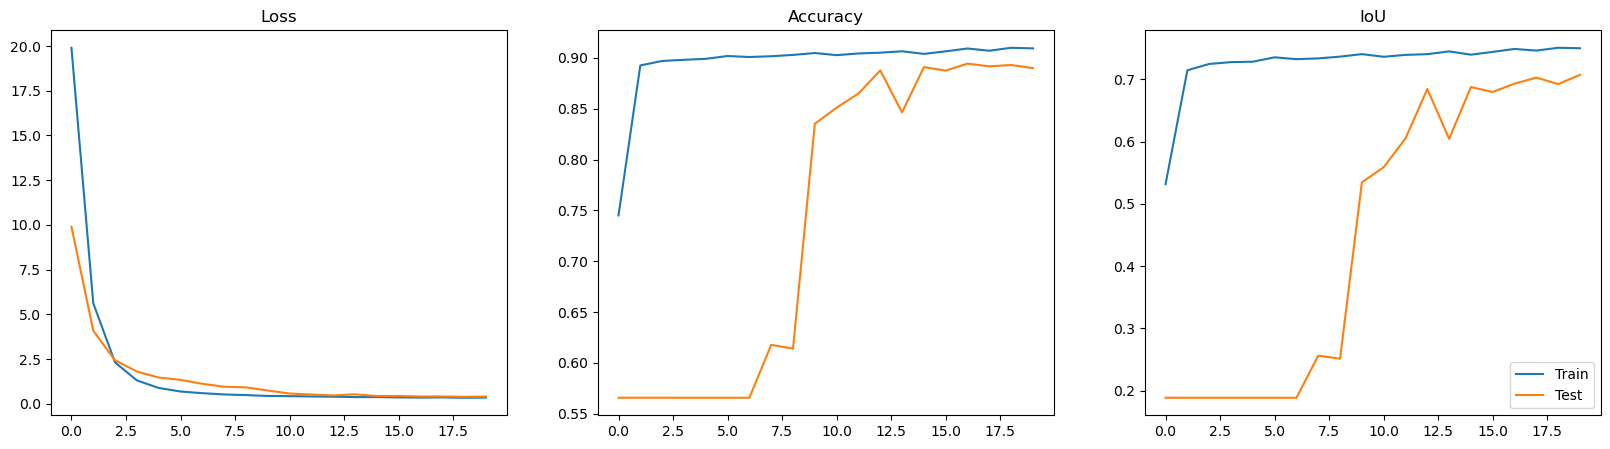

In [33]:
plot_history(trainHist)

In [20]:
print("Mean iou:", get_iou(model, test_batches))

Mean iou: [0.87723257 0.81541821 0.42322017]


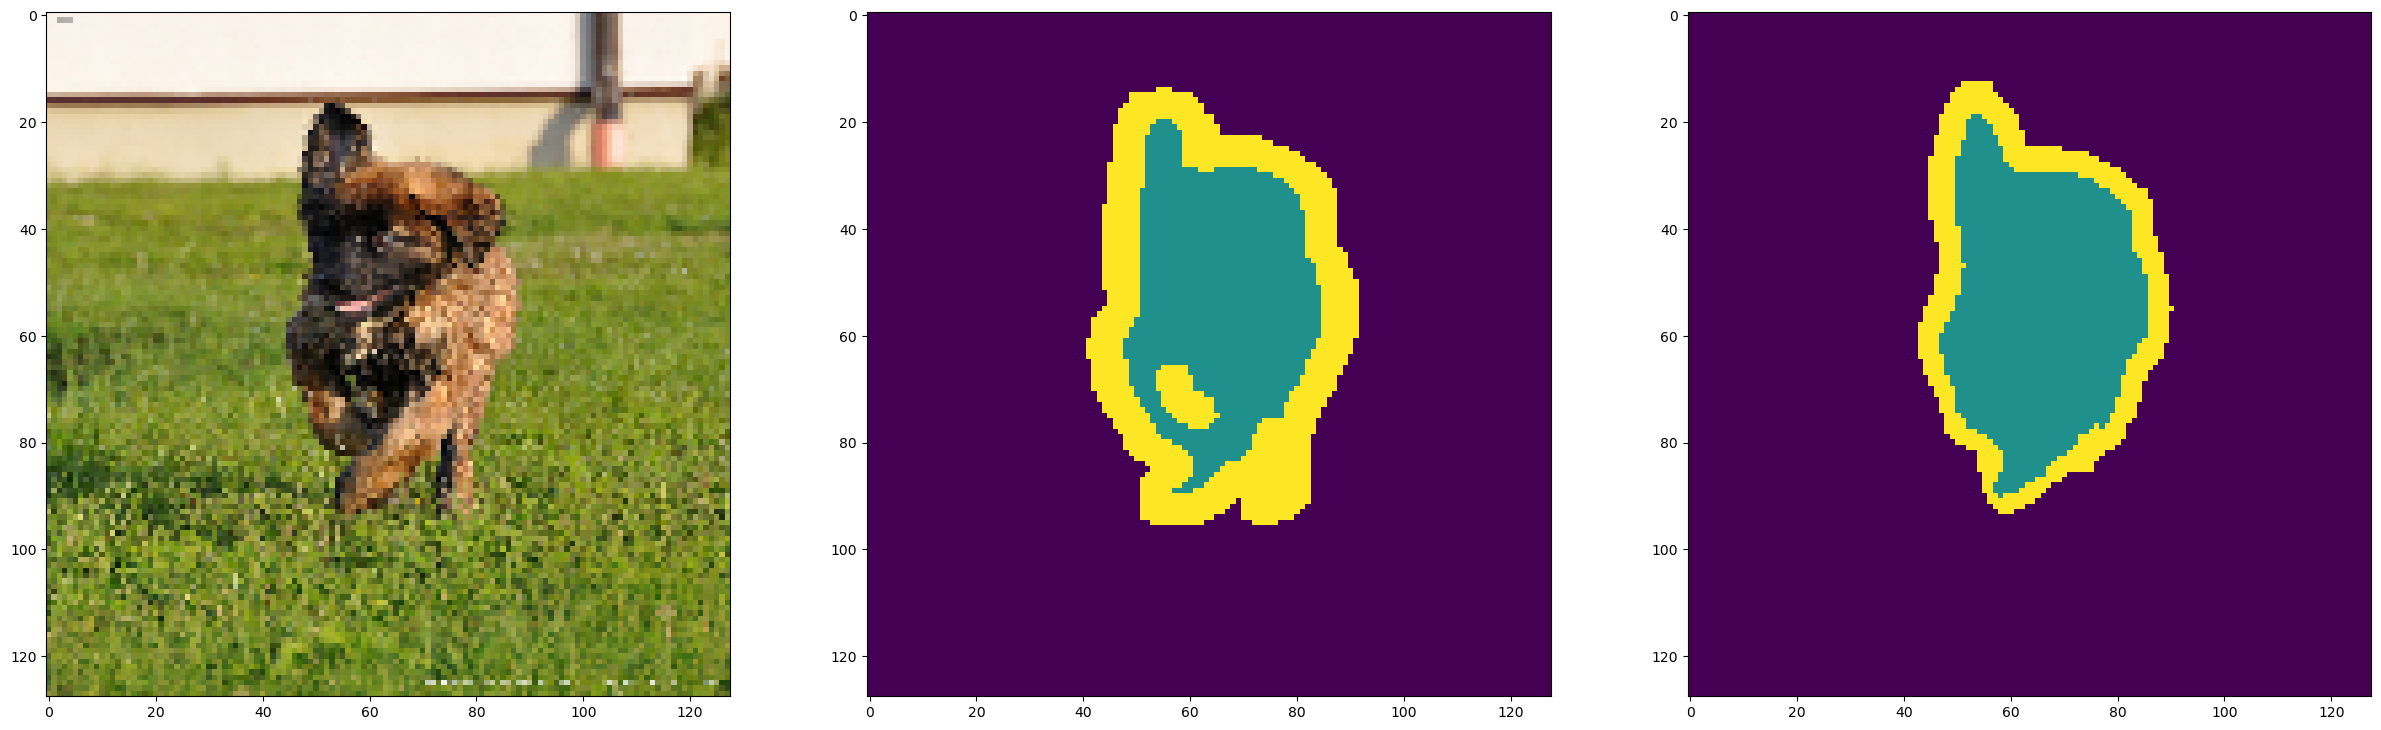

In [21]:
plot_image_comparison(model, test_batches)

Same experiment but with regularization

In [22]:
model_reg = Unet(num_classes=OUTPUT_CLASSES, reg=0.001)
model_reg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy',iou])

In [23]:
trainHist_reg = model_reg.fit(x=train_batches, steps_per_epoch=STEPS_PER_EPOCH, epochs=20, validation_data=test_batches, validation_steps=10)

Epoch 1/20
57/57 [==============================] - 18s 269ms/step - loss: 3.4783 - accuracy: 0.7040 - iou: 0.5196 - val_loss: 2.9803 - val_accuracy: 0.3718 - val_iou: 0.1573
Epoch 2/20
57/57 [==============================] - 15s 257ms/step - loss: 1.9140 - accuracy: 0.8962 - iou: 0.7290 - val_loss: 2.1272 - val_accuracy: 0.3376 - val_iou: 0.1256
Epoch 3/20
57/57 [==============================] - 14s 254ms/step - loss: 1.2582 - accuracy: 0.9055 - iou: 0.7444 - val_loss: 1.6003 - val_accuracy: 0.5952 - val_iou: 0.3155
Epoch 4/20
57/57 [==============================] - 15s 255ms/step - loss: 0.9137 - accuracy: 0.9090 - iou: 0.7505 - val_loss: 1.5031 - val_accuracy: 0.3743 - val_iou: 0.1558
Epoch 5/20
57/57 [==============================] - 15s 256ms/step - loss: 0.7121 - accuracy: 0.9127 - iou: 0.7574 - val_loss: 1.1269 - val_accuracy: 0.6866 - val_iou: 0.4074
Epoch 6/20
57/57 [==============================] - 15s 256ms/step - loss: 0.5970 - accuracy: 0.9124 - iou: 0.7573 - val_loss

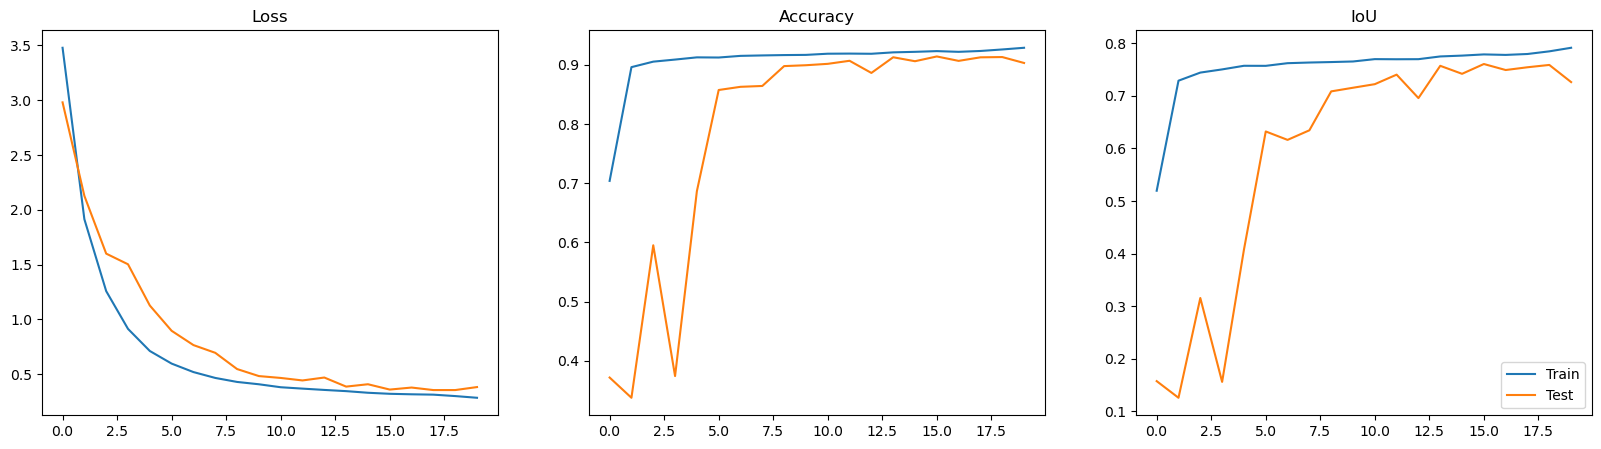

In [34]:
plot_history(trainHist_reg)

In [25]:
print("Mean iou:", get_iou(model_reg, test_batches))

Mean iou: [0.89875997 0.84148387 0.43785146]


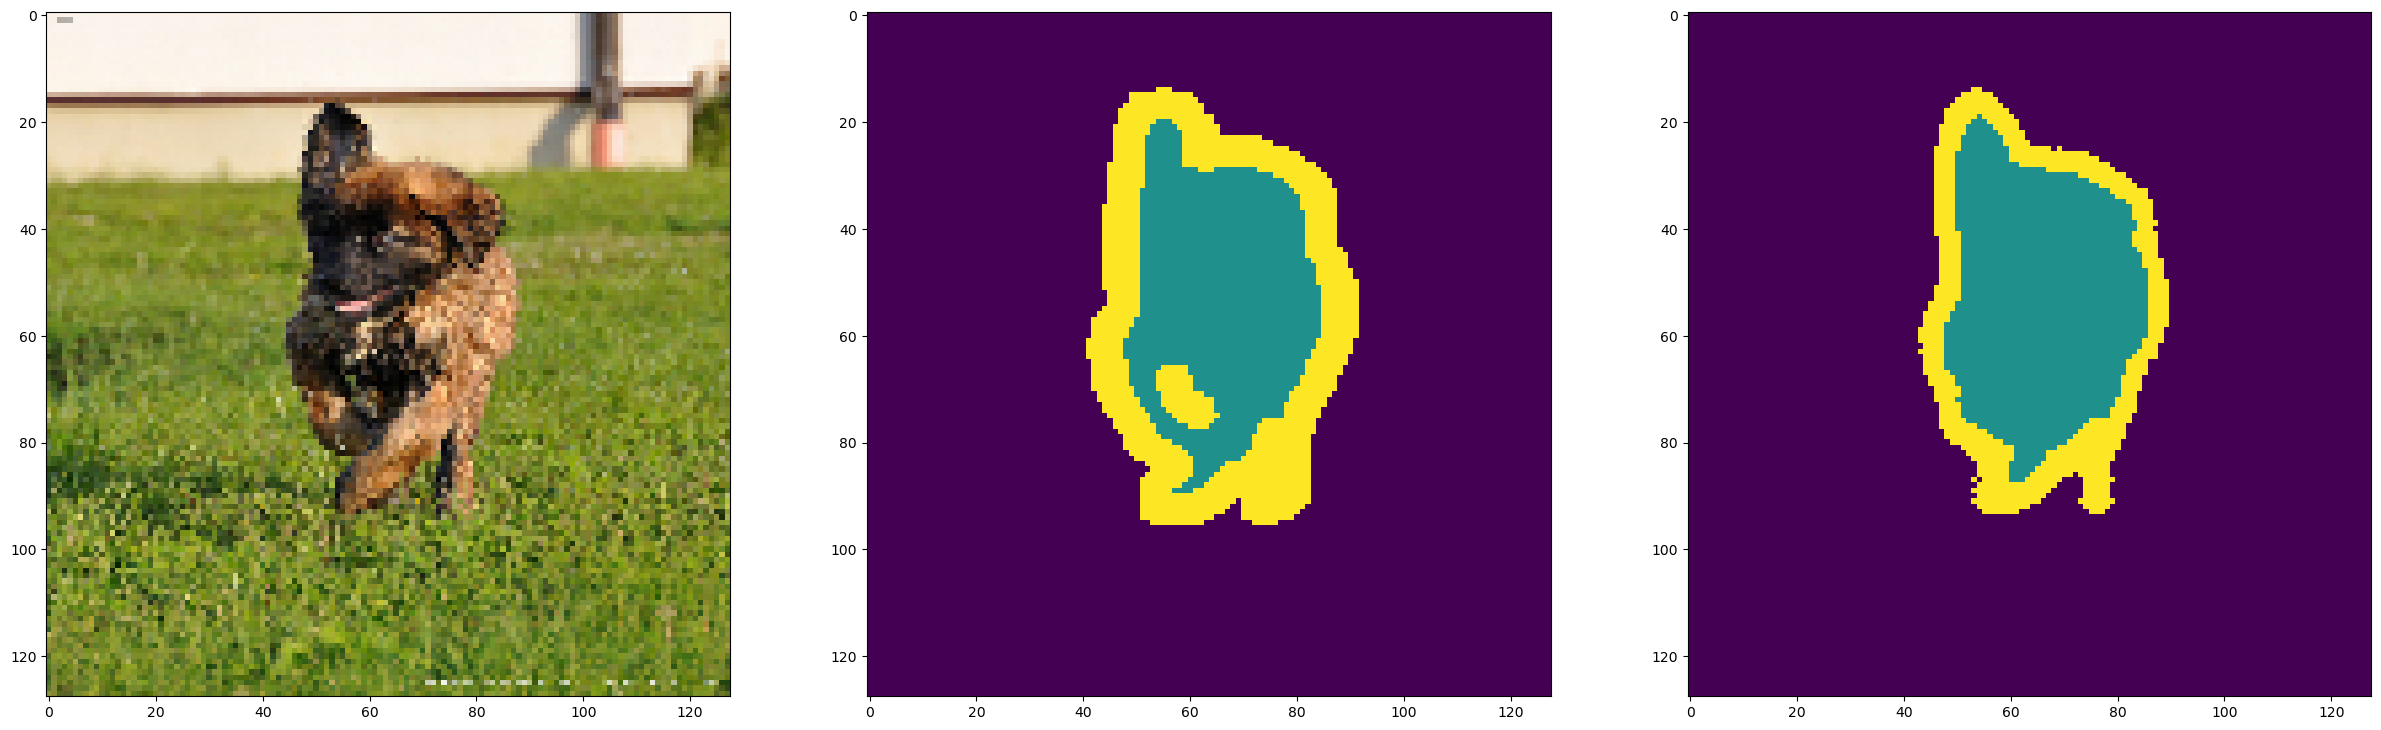

In [26]:
plot_image_comparison(model_reg, test_batches)

# Decoder variation

Second decoder model with same structure as the first decoder but with a skip connection added. The skip connection is a 1-D convolution with batch normalization.

In [12]:
def conv_block(n, kernel_size, pooling=True):
    layers_ = [layers.Conv2D(n[0],kernel_size,activation="relu", padding='same'),\
                       layers.BatchNormalization(),\
                       layers.Conv2D(n[1],kernel_size,activation="relu", padding='same'),\
                       layers.BatchNormalization()]
    if pooling:
        layers_.append(layers.MaxPooling2D((2,2)))
    return tf.keras.Sequential(layers_)

class ResBlock(layers.Layer):
    def __init__(self, n, kernel_size=(3,3), pooling=True):
        super(ResBlock, self).__init__()

        self.convBlock = conv_block(n, kernel_size, pooling=pooling)
                      
        skip_layers = [layers.Conv2D(n[1],1,activation="relu", padding='same'),\
                        layers.BatchNormalization()]
        if pooling:
            skip_layers.append(layers.MaxPooling2D((2,2)))
                      
        self.skip = tf.keras.Sequential(skip_layers)
        self.out  = layers.Add()

    def call(self, x_input):
        x_conv = self.convBlock(x_input)
        x_skip = self.skip(x_input)
        x_out = self.out([x_conv, x_skip])
        return tf.nn.relu(x_out)

In [13]:
class Decoder2(tf.keras.Model):
    def __init__(self,num_classes=3, reg=0.001):
        super(Decoder2, self).__init__()
        
        #Deconvolutions
        def genDeconv(filters, kernel=(2,2), strides=(2,2)):
            return layers.Conv2DTranspose(filters, kernel, padding="same", activation="relu", strides=(2,2), kernel_regularizer=l2(reg))
        
        deconv_1 = genDeconv(576)
        deconv_2 = genDeconv(192)
        deconv_3 = genDeconv(144)
        deconv_4 = genDeconv(96)
        deconv_5 = genDeconv(48) #To reescale back to 128x128
        
        self.deconv = [deconv_1, deconv_2, deconv_3, deconv_4, deconv_5]
        
        #Processing layers
        def genConv(filters,kernels=[(3,3),(3,3)]):
            return tf.keras.Sequential([layers.BatchNormalization(),\
                                        layers.Conv2D(filters[0], kernels[0], padding="same", activation="relu", kernel_regularizer=l2(reg)),\
                                        layers.BatchNormalization(),\
                                        layers.Conv2D(filters[1], kernels[1], padding="same", activation="relu", kernel_regularizer=l2(reg)),
                                        layers.BatchNormalization()])
        
        #Extra layer at the end to rescale to 128x128
        self.block = [ResBlock((900,768), pooling=False),\
                      ResBlock((576,384), pooling=False),\
                      ResBlock((337,288), pooling=False),\
                      ResBlock((240,192), pooling=False),\
                      ResBlock((96,64), pooling=False),\
                      ResBlock((36,24), pooling=False)]  
        
        #Output layer
        self.out = layers.Dense(num_classes)

    def call(self, inputs, training=False):
        
        prev = self.block[0](inputs[4])
        for i in range(4):
            concat = tf.concat([self.deconv[i](prev),inputs[3-i]], axis=3)
            prev = self.block[i+1](concat)
            
        #Extra layer to get back to 128x128
        rescale = self.deconv[4](prev)
        prev = self.block[5](rescale)

        return self.out(prev)   

In [14]:
class Unet2(tf.keras.Model):
    
    def __init__(self, num_classes=3, reg=0.001):
        super(Unet2, self).__init__()


        # Create the feature extraction model
        self.encoder = base_model# TODO

        # In case you load a pretrained encoder and dont want to train it to speed up computation
        #self.encoder.trainable = False
        
        self.decoder = Decoder2(num_classes=num_classes, reg=reg)
        
    def call(self, inputs, training = False):
        
        embedding = self.encoder(inputs)

        # Here the embeddings is a list of outputs for each U-Net level
        
        pred = self.decoder(embedding)
        
        return pred

# Training Decoder Variation

In [30]:
model2 = Unet2(num_classes=OUTPUT_CLASSES, reg=None)
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy',iou])

In [35]:
trainHist2 = model2.fit(x=train_batches,steps_per_epoch=STEPS_PER_EPOCH,epochs=20, validation_data=test_batches, validation_steps=10)

Epoch 1/20
57/57 [==============================] - 21s 364ms/step - loss: 7.9889 - accuracy: 0.7413 - iou: 0.4742 - val_loss: 5.0034 - val_accuracy: 0.7057 - val_iou: 0.4152
Epoch 2/20
57/57 [==============================] - 23s 350ms/step - loss: 2.4798 - accuracy: 0.8858 - iou: 0.6942 - val_loss: 1.6546 - val_accuracy: 0.8559 - val_iou: 0.6050
Epoch 3/20
57/57 [==============================] - 20s 347ms/step - loss: 1.0347 - accuracy: 0.9023 - iou: 0.7326 - val_loss: 0.8907 - val_accuracy: 0.8886 - val_iou: 0.6972
Epoch 4/20
57/57 [==============================] - 20s 349ms/step - loss: 0.5738 - accuracy: 0.9100 - iou: 0.7480 - val_loss: 0.5681 - val_accuracy: 0.8981 - val_iou: 0.7282
Epoch 5/20
57/57 [==============================] - 20s 347ms/step - loss: 0.3941 - accuracy: 0.9143 - iou: 0.7577 - val_loss: 0.4758 - val_accuracy: 0.8746 - val_iou: 0.6382
Epoch 6/20
57/57 [==============================] - 20s 347ms/step - loss: 0.3091 - accuracy: 0.9184 - iou: 0.7652 - val_loss

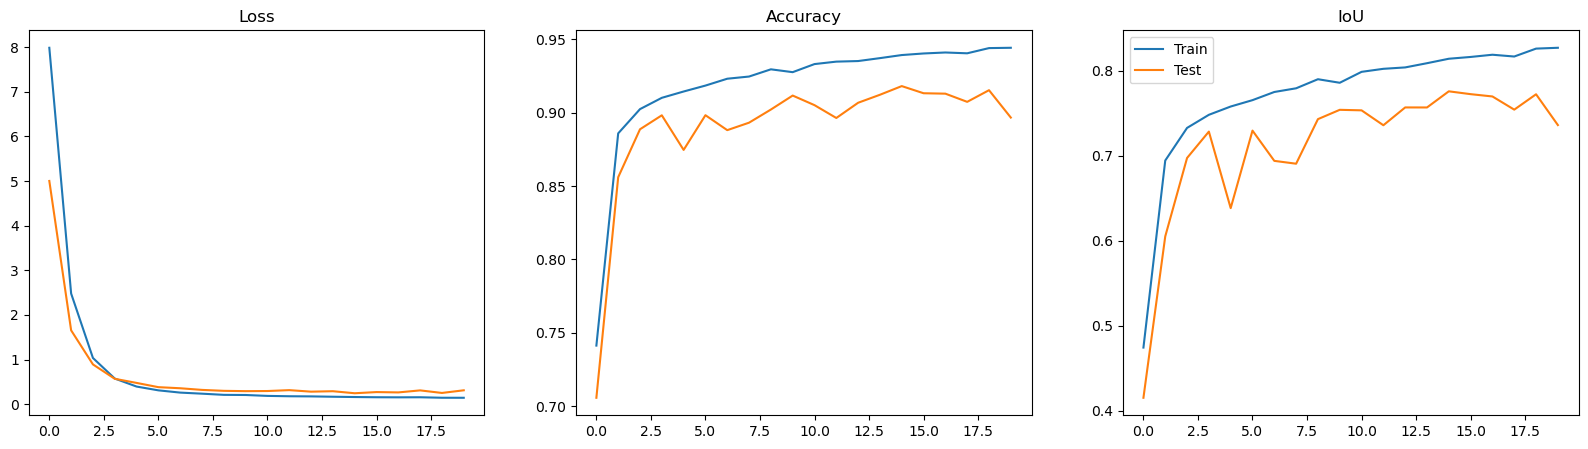

In [36]:
plot_history(trainHist2)

In [37]:
print("Mean iou:",get_iou(model2, test_batches))

Mean iou: [0.91228376 0.79972587 0.49309488]


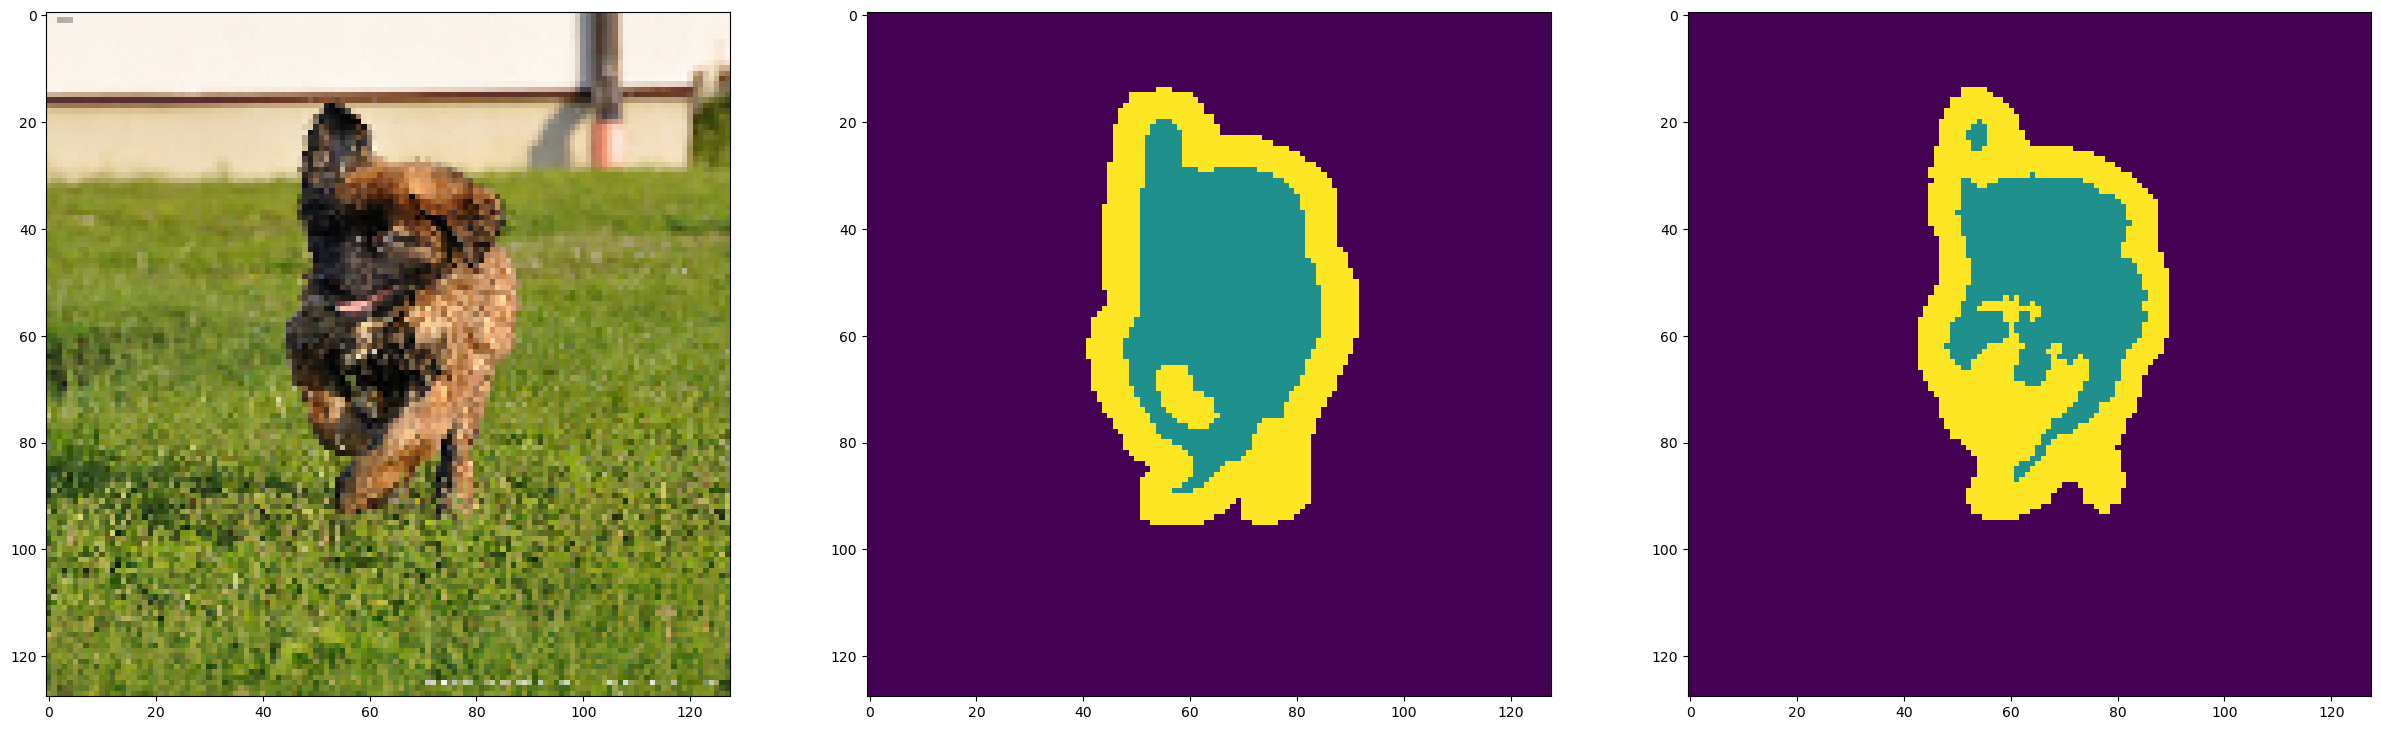

In [38]:
plot_image_comparison(model2, test_batches)

Same experiment but with regularization

In [18]:
model2_reg = Unet2(num_classes=OUTPUT_CLASSES, reg=0.001)
model2_reg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy',iou])
trainHist2_reg = model2_reg.fit(x=train_batches,steps_per_epoch=STEPS_PER_EPOCH,epochs=20, validation_data=test_batches, validation_steps=10)

Epoch 1/20
57/57 [==============================] - 26s 371ms/step - loss: 1.5294 - accuracy: 0.7230 - iou: 0.4806 - val_loss: 1.5419 - val_accuracy: 0.6796 - val_iou: 0.4390
Epoch 2/20
57/57 [==============================] - 25s 351ms/step - loss: 0.6685 - accuracy: 0.8959 - iou: 0.7196 - val_loss: 0.5818 - val_accuracy: 0.8912 - val_iou: 0.7217
Epoch 3/20
57/57 [==============================] - 20s 348ms/step - loss: 0.4647 - accuracy: 0.9076 - iou: 0.7444 - val_loss: 0.4653 - val_accuracy: 0.8947 - val_iou: 0.7303
Epoch 4/20
57/57 [==============================] - 20s 351ms/step - loss: 0.3661 - accuracy: 0.9147 - iou: 0.7597 - val_loss: 0.3922 - val_accuracy: 0.9010 - val_iou: 0.7347
Epoch 5/20
57/57 [==============================] - 20s 350ms/step - loss: 0.3132 - accuracy: 0.9188 - iou: 0.7679 - val_loss: 0.3925 - val_accuracy: 0.8926 - val_iou: 0.7270
Epoch 6/20
57/57 [==============================] - 20s 350ms/step - loss: 0.2825 - accuracy: 0.9210 - iou: 0.7731 - val_loss

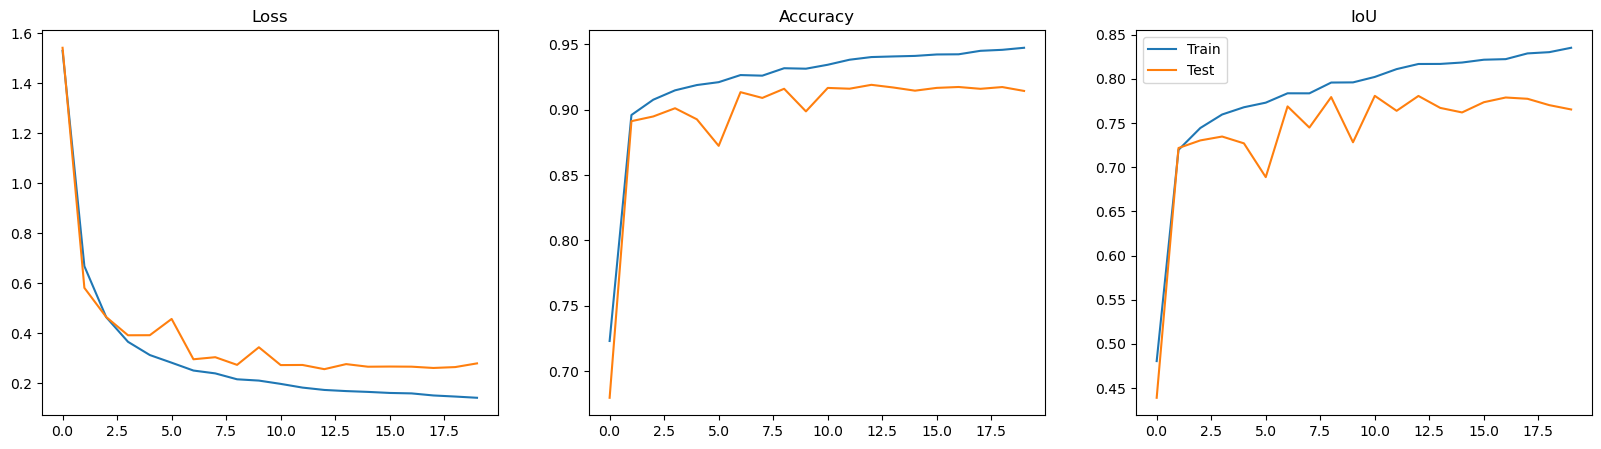

In [19]:
plot_history(trainHist2_reg)

In [20]:
print("Mean iou:",get_iou(model2_reg, test_batches))

Mean iou: [0.91448301 0.85340198 0.52876291]


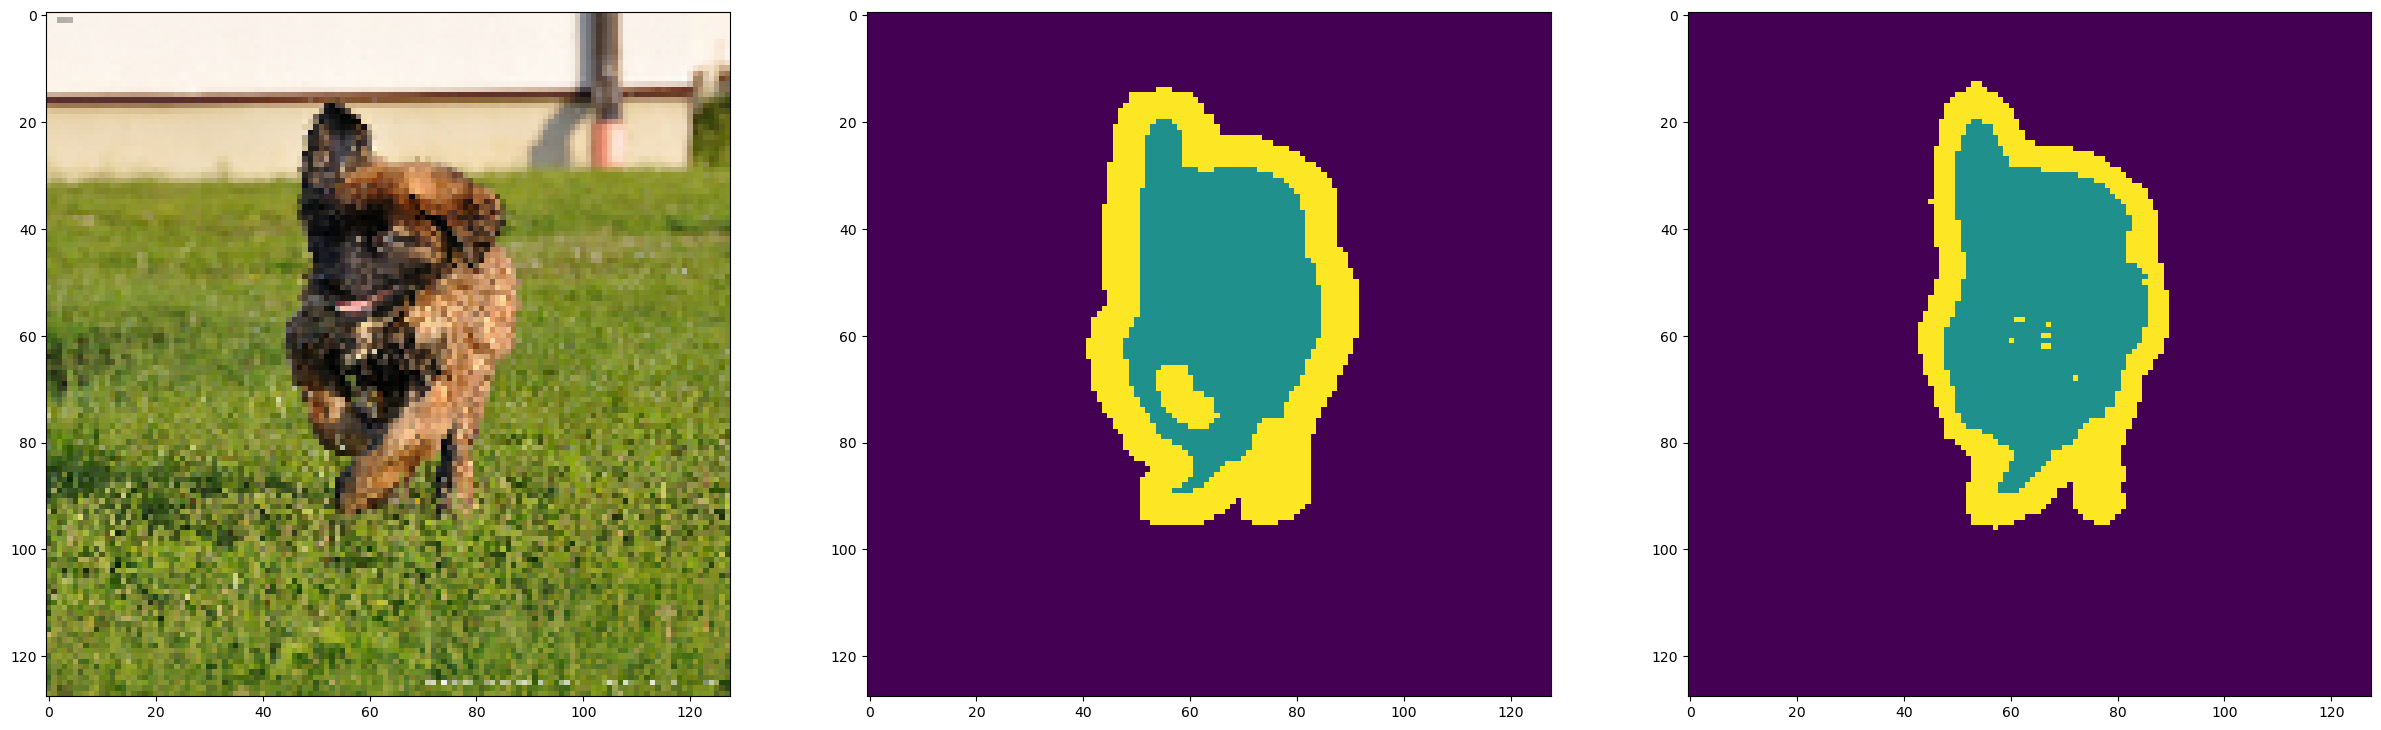

In [21]:
plot_image_comparison(model2_reg, test_batches)

# Results and conclusions

If we recopilate the previous experiments in a final table we obtain:

| Method | Loss | Accuracy | IoU |
| --- | --- | --- | --- |
| U-Net | 0.4094 | 0.8900 | 0.7071 |
| U-Net with reg | 0.3829 | 0.9032 | 0.7263 |
| U-Net 2 | 0.3102 | 0.8966 | 0.7359 |
| U-Net 2 with reg | **0.2798** |  **0.9143** |  **0.7654** |

Here we can observe that out of the options we tried, the variation in the U-Net decoder (U-Net 2), i.e., the addition of a skip connection is the most important factor. However, the regularization term also helps the model performance. This can be seen also by the fact that all the metrics (accuracy, loss and IoU) return the same ranking of the different models, proving the consistency of this model ranking.

# Extra experiment : Encoder Finetunning

MobileNet2 is a highly optimized model. Nevertheless, we will try to fine tuned it and see if there is an increase of performance or if it would reduce the model performance.

We will use the best performing model (U-Net 2 with reg.) for this experiment. For a fair comparison, we will train it for 15 epochs before finetunning for another 5 epochs. These way, the results should be comparable to training for 20 epochs without finetunning (previous result).

In [15]:
model2_reg = Unet2(num_classes=OUTPUT_CLASSES, reg=0.001)
model2_reg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy',iou])
trainHist2_reg = model2_reg.fit(x=train_batches,steps_per_epoch=STEPS_PER_EPOCH,epochs=15, validation_data=test_batches, validation_steps=10)

Epoch 1/15
57/57 [==============================] - 37s 366ms/step - loss: 1.5244 - accuracy: 0.7320 - iou: 0.5072 - val_loss: 1.0157 - val_accuracy: 0.8416 - val_iou: 0.5958
Epoch 2/15
57/57 [==============================] - 25s 349ms/step - loss: 0.6683 - accuracy: 0.8971 - iou: 0.7242 - val_loss: 0.6886 - val_accuracy: 0.8706 - val_iou: 0.6560
Epoch 3/15
57/57 [==============================] - 20s 347ms/step - loss: 0.4598 - accuracy: 0.9101 - iou: 0.7493 - val_loss: 0.4999 - val_accuracy: 0.8751 - val_iou: 0.6504
Epoch 4/15
57/57 [==============================] - 20s 347ms/step - loss: 0.3707 - accuracy: 0.9138 - iou: 0.7565 - val_loss: 0.5228 - val_accuracy: 0.8632 - val_iou: 0.6560
Epoch 5/15
57/57 [==============================] - 20s 348ms/step - loss: 0.3141 - accuracy: 0.9196 - iou: 0.7693 - val_loss: 0.3583 - val_accuracy: 0.8990 - val_iou: 0.7109
Epoch 6/15
57/57 [==============================] - 20s 347ms/step - loss: 0.2796 - accuracy: 0.9224 - iou: 0.7750 - val_loss

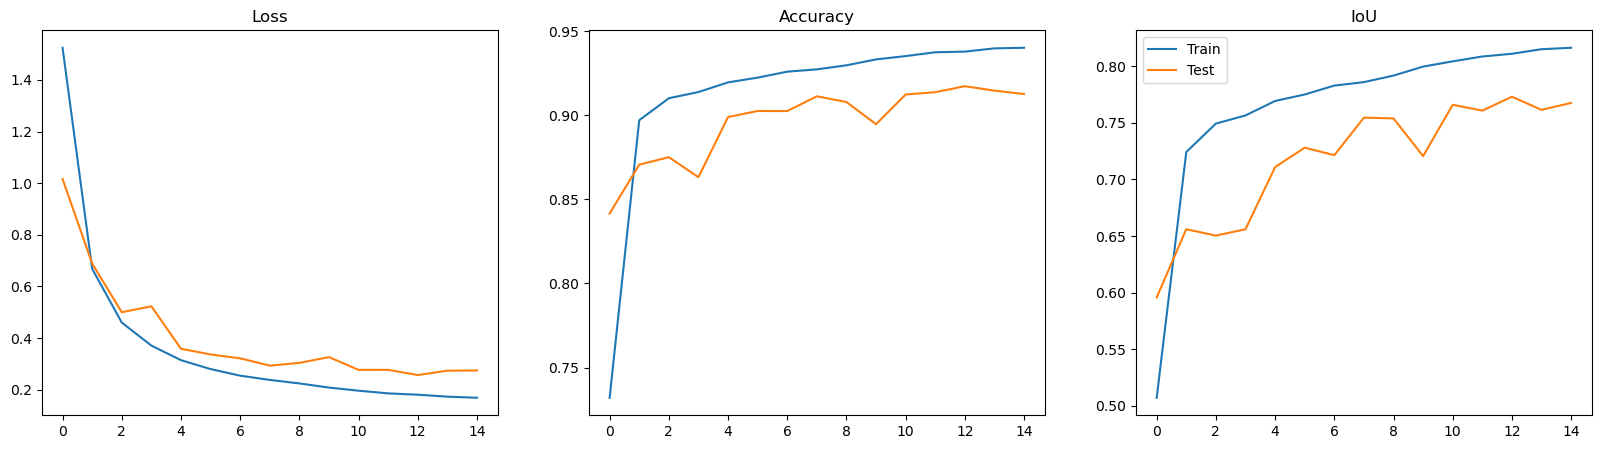

In [16]:
plot_history(trainHist2_reg)

In [17]:
print("Mean iou:",get_iou(model2_reg, test_batches))

Mean iou: [0.91636683 0.84258787 0.53976926]


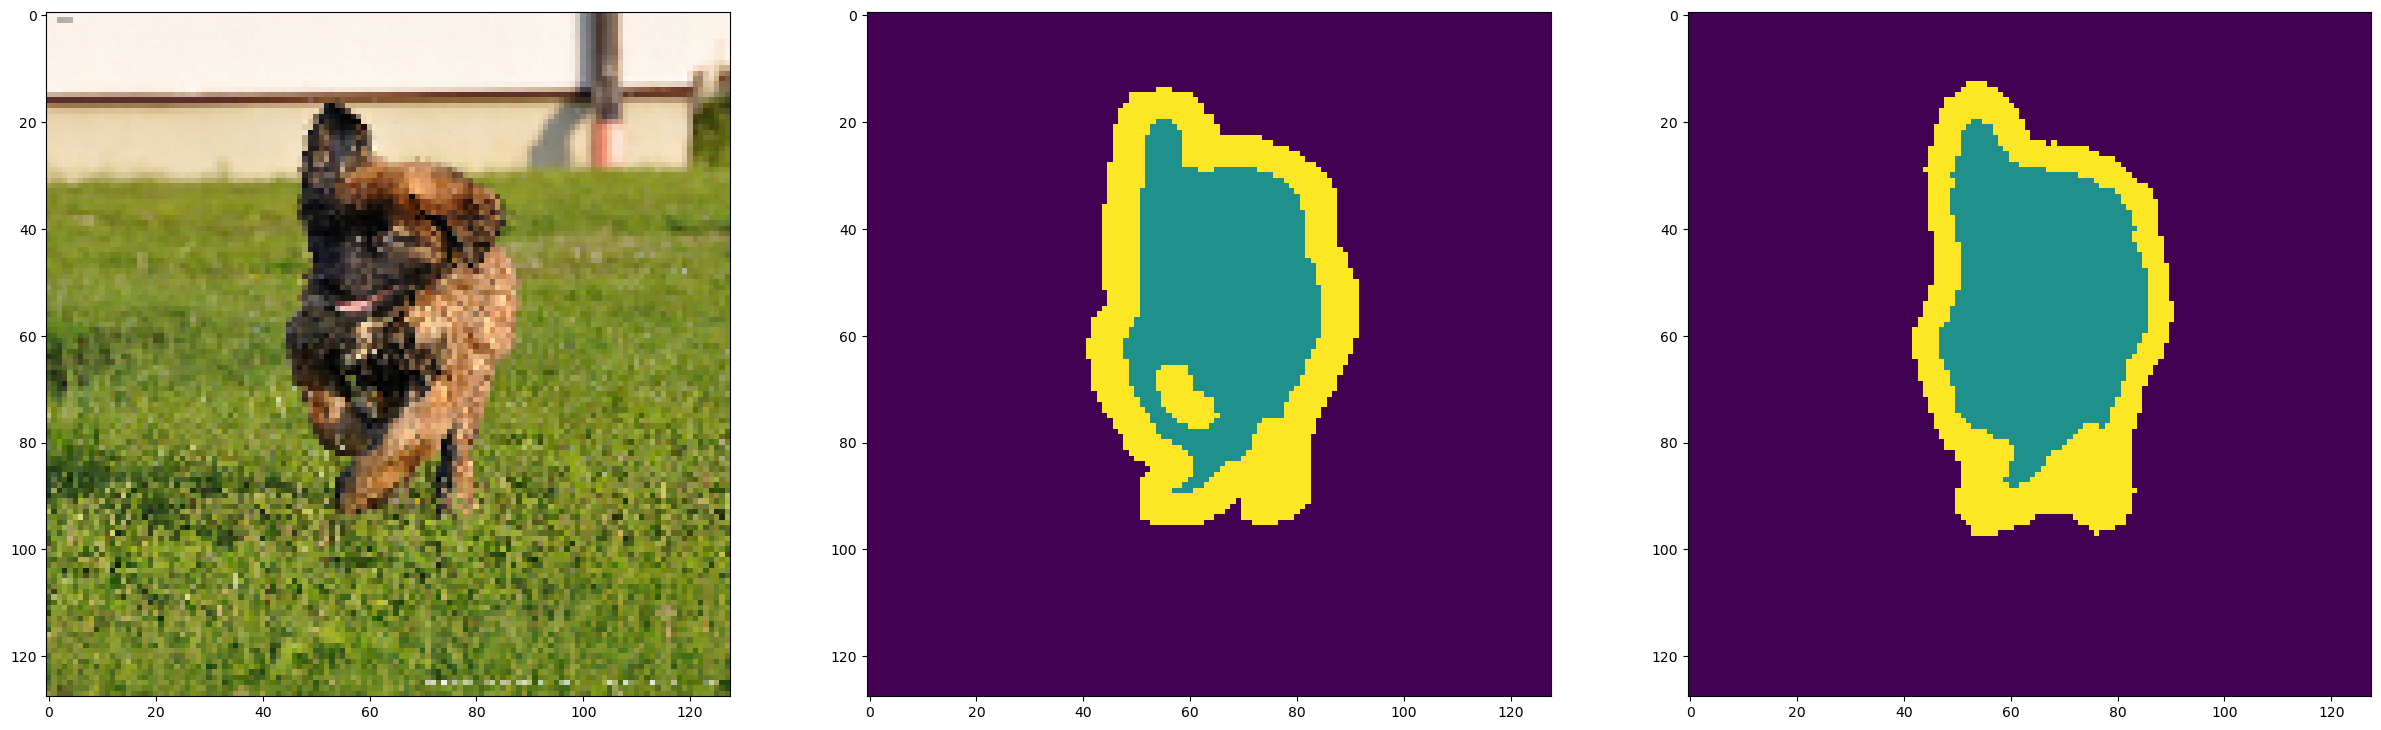

In [18]:
plot_image_comparison(model2_reg, test_batches)

In [19]:
model2_reg.trainable = True
trainHist2_reg_finetune = model2_reg.fit(x=train_batches,steps_per_epoch=STEPS_PER_EPOCH,epochs=5, validation_data=test_batches, validation_steps=10)

Epoch 1/5
57/57 [==============================] - 20s 350ms/step - loss: 0.1631 - accuracy: 0.9415 - iou: 0.8202 - val_loss: 0.2943 - val_accuracy: 0.9078 - val_iou: 0.7576
Epoch 2/5
57/57 [==============================] - 20s 350ms/step - loss: 0.1602 - accuracy: 0.9419 - iou: 0.8203 - val_loss: 0.2673 - val_accuracy: 0.9153 - val_iou: 0.7632
Epoch 3/5
57/57 [==============================] - 20s 348ms/step - loss: 0.1549 - accuracy: 0.9435 - iou: 0.8248 - val_loss: 0.2665 - val_accuracy: 0.9149 - val_iou: 0.7693
Epoch 4/5
57/57 [==============================] - 20s 347ms/step - loss: 0.1452 - accuracy: 0.9466 - iou: 0.8326 - val_loss: 0.2702 - val_accuracy: 0.9141 - val_iou: 0.7695
Epoch 5/5
57/57 [==============================] - 20s 347ms/step - loss: 0.1460 - accuracy: 0.9456 - iou: 0.8308 - val_loss: 0.2581 - val_accuracy: 0.9167 - val_iou: 0.7710


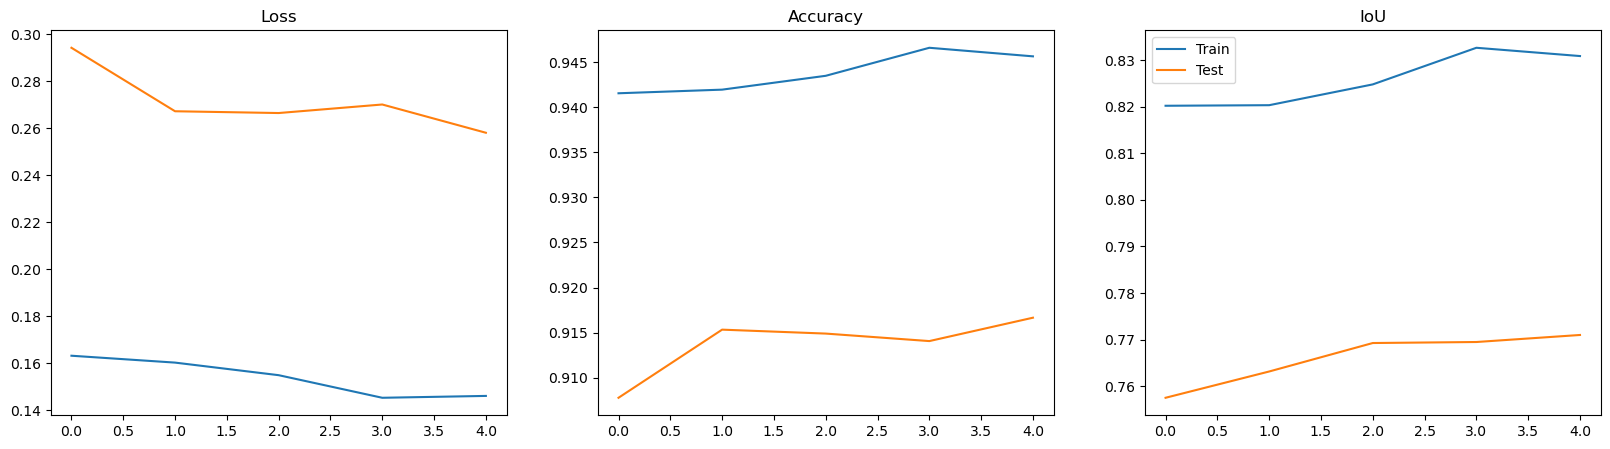

In [20]:
plot_history(trainHist2_reg_finetune)

In [21]:
print("Mean iou:",get_iou(model2_reg, test_batches))

Mean iou: [0.91888937 0.85664585 0.53537923]


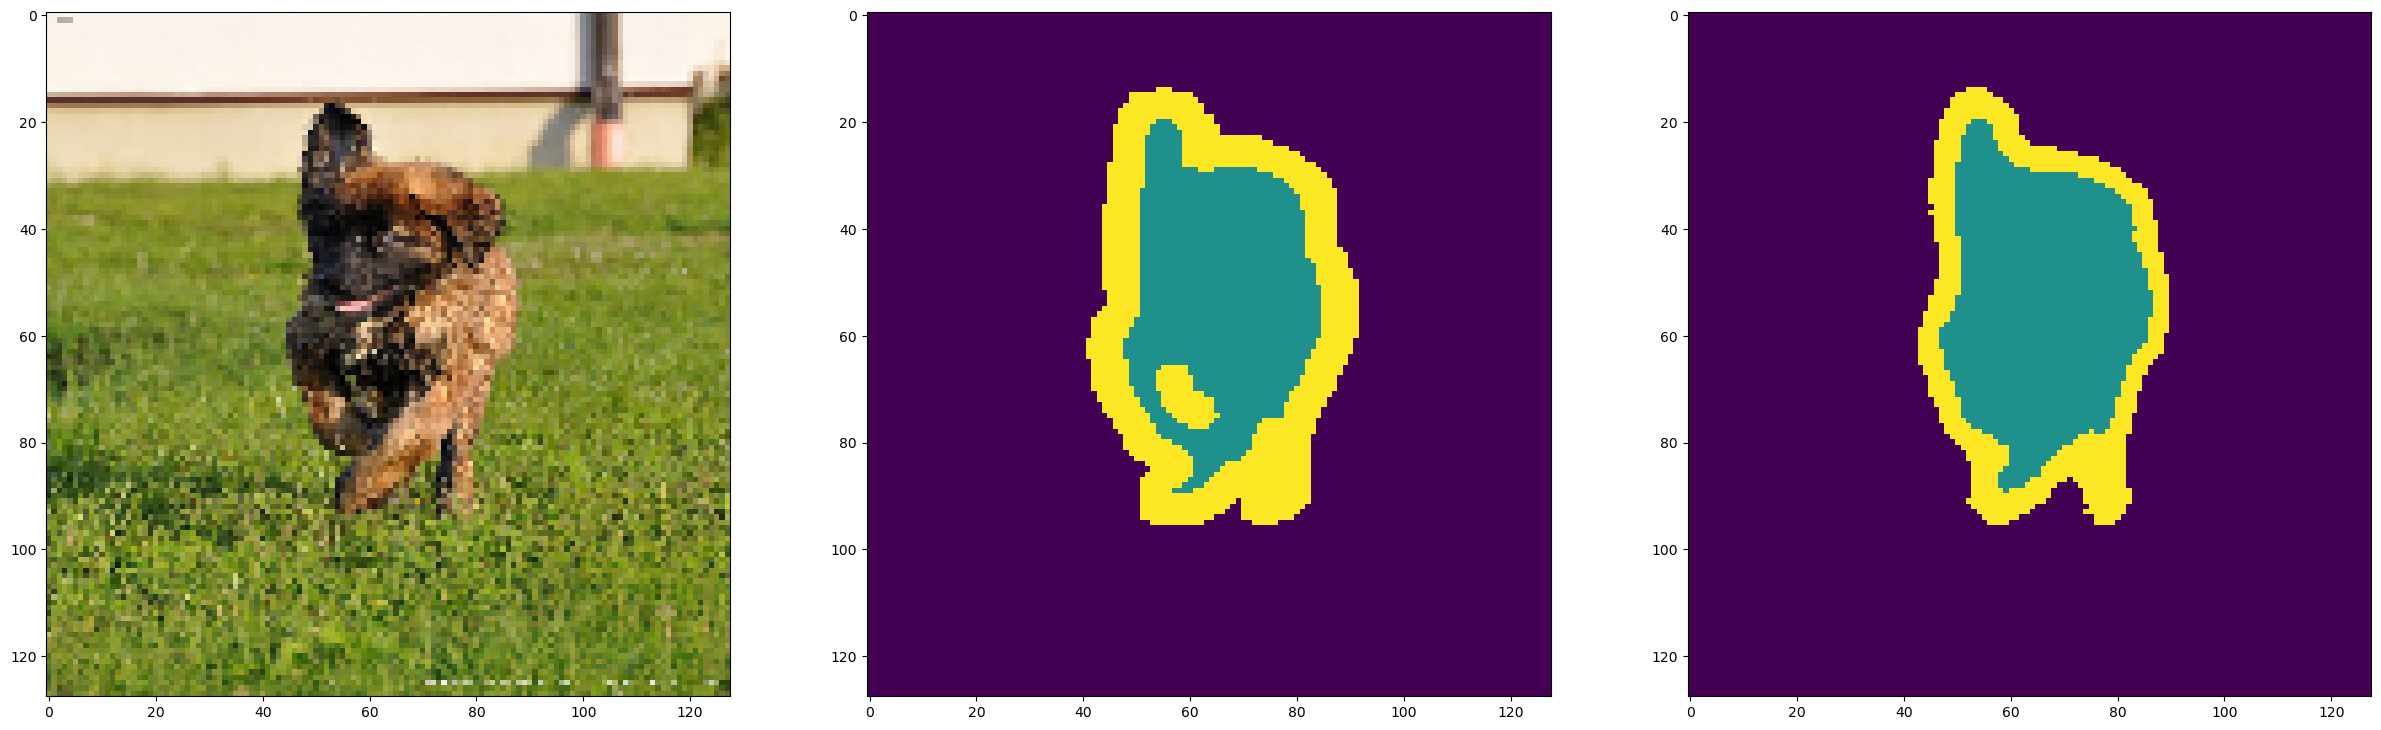

In [22]:
plot_image_comparison(model2_reg, test_batches)

# Finetuning results

The results obtained are:

| Method | Loss | Accuracy | IoU |
| --- | --- | --- | --- |
| U-Net 2 with reg | 0.2798 |  0.9143 |  0.7654 |
| U-Net 2 with reg (+ finetuning) | **0.2581** |  **0.9167** | **0.7710** |

There are some small improvements when doing finetuning. However, this could be due to random initialization or other random factors. More experiments would be needded as well as calculating the mean and standard deviation of the previous experiments to asure the validity of these results.

Nevertheless, as mentioned before MobileNet2 is already highly tuned. Therefore it is not expected to achieve high performance improvements with finetuning.